In [40]:
import csv
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt


def spectraReader(file_path):
    content = []
    with open(file_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            content.append(row)
    
    content = content[3:]

    x = [float(item[0]) for item in content][::-1] 
    y = [float(item[1]) for item in content][::-1]

    x_new = np.arange(np.floor(min(x)), np.ceil(max(x)) + 0.1, 0.1)
    cs = interpolate.CubicSpline(x, y)
    y_new = cs(x_new)

    while x_new[0] > 400:
        x_new = np.concatenate((np.array([x_new[0] - 0.1]), x_new))
        y_new = np.concatenate((np.array([0]), y_new))
    
    while len(x_new) < 36000:
        x_new = np.concatenate((x_new, np.array([x_new[-1] + 0.1])))
        y_new = np.concatenate((y_new, np.array([0])))
 
    return x_new, y_new

class Chemical:
    def __init__(self, name, filename, mass, minConc, maxConc, folder="Spectral Data/"):
        self.name = name
        self.mass = mass
        self.minConc = minConc
        self.maxConc = maxConc
        self.filename = filename
        self.relativeIntensity = 1
        
        wavenumber, intensity = spectraReader(folder + filename)
        self.wavenumber = wavenumber
        self.intensity = intensity
    def plot(self):
        plt.plot(self.wavenumber, self.intensity)
        plt.title(self.name)
        plt.xlabel("wavenumbers / cm-1")
        plt.ylabel("absorbance")
        plt.show()


def ChemicalConcentrationReader(file_path="Blood Chemical Concentration.csv", spectraFolder="Spectral Data/"):
    content = []
    with open(file_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            content.append(row)
    
    content = content[1:]

    data = []
    for row in content:
        name = row[0]
        filename = row[1]
        mass = float(row[2])
        minConc = float(row[3])
        maxConc = float(row[4])
        chemical = Chemical(
            name,
            filename,
            mass,
            minConc,
            maxConc,
            spectraFolder
        )
        data.append(chemical)

    maxMass = max(data, key=lambda x: x.mass)
    maxMass = maxMass.mass

    for item in data:
        item.relativeIntensity = item.mass/maxMass
    return data


In [41]:
import random, pickle

class Mixture:
    def __init__(self, chemicals):
        self.chemicals = chemicals
        self.wavenumber = np.arange(400, 4000, 0.1)
        self.absorption = np.zeros(len(self.wavenumber))

        self.composition = []
        # {
        #     "chemical": chemical.name,
        #     "concentration": concentration
        # }

        concentrations = [random.uniform(chemical.minConc, chemical.maxConc) for chemical in chemicals]
        self.setConc(chemicals, concentrations)
    
    def relativeIntensitive_cal(self, concentration, chemical):
        absorption =  concentration * chemical.relativeIntensity * chemical.intensity    
        return absorption


    def setConc(self, chemicals, concentrations):
        self.absorption = np.zeros(len(self.wavenumber))
        for i in range(len(chemicals)):
            chemical = chemicals[i]
            concentration = concentrations[i]
            absorption_ =  self.relativeIntensitive_cal(concentration, chemical)   
            self.absorption += absorption_
            composition_ = {
                "chemical": chemical.name,
                "concentration": concentration
            }
            self.composition.append(composition_)

        self.transmittance = [ 10**(-1 * item) for item in self.absorption]   

    def removeBackground(self, chemicalName):
        for i in range(len(self.chemicals)):
            chemical = self.chemicals[i]
            if chemical.name == chemicalName:
                concentration = self.composition[i]["concentration"]
                absorption =  self.relativeIntensitive_cal(concentration, chemical) 
                self.absorption = self.absorption - absorption

                self.transmittance = [ 10**(-1 * item) for item in self.absorption]   
    
    def normalizedWithBackground(self, chemicalName):
        for i in range(len(self.chemicals)):
            chemical = self.chemicals[i]
            if chemical.name == chemicalName:
                concentration = self.composition[i]["concentration"]
                absorption =  self.relativeIntensitive_cal(concentration, chemical) 

                max_abs_value = max(abs(x) for x in absorption)
                if max_abs_value == 0:
                    max_abs_value = 1
                scale_factor = 1 / max_abs_value

                self.absorption = self.absorption * scale_factor
                self.transmittance = [ 10**(-1 * item) for item in self.absorption]   


    def plot(self, overlap="separate", type="transmittance"):
        if overlap == "separate":
            fig, ax = plt.subplots()
            if type == "absorbance":
                ax.plot(self.wavenumber, self.absorption)
                ax.invert_xaxis()
                ax.set_xlabel("wavenumbers / cm-1")
                ax.set_ylabel("absorbance")
            elif type == "transmittance":
                ax.plot(self.wavenumber, self.transmittance)
                ax.invert_xaxis()
                ax.set_xlabel("wavenumbers / cm-1")
                ax.set_ylabel("Transmittance")
        else:
            if type == "absorbance":
                plt.plot(self.wavenumber, self.absorption, alpha=0.5)
                plt.xlabel("wavenumbers / cm-1")
                plt.ylabel("absorbance")
            elif type == "transmittance":
                plt.plot(self.wavenumber, self.transmittance, alpha=0.5)
                plt.xlabel("wavenumbers / cm-1")
                plt.ylabel("Transmittance")
    
    def save(self, filename, folder):
        data = {
            "wavenumber": self.wavenumber,
            "intensity": self.intensity,
            "composition": self.composition
        }
        data_pickle = pickle.dumps(data)

        filePath = folder + str(filename) + ".pickle"
        log = open(filePath, "wb")
        log.write(data_pickle)
        log.flush()

In [ ]:
concentrationList = [
    0.017,
    0.75,
    6.48,
    0.11,
    7.8,
    2.22,
    30,
    8.33,
    0.42,
    0.11,
    55600
]

In [42]:
chemicals = ChemicalConcentrationReader()
# for chemical in chemicals:
#     chemical.plot()

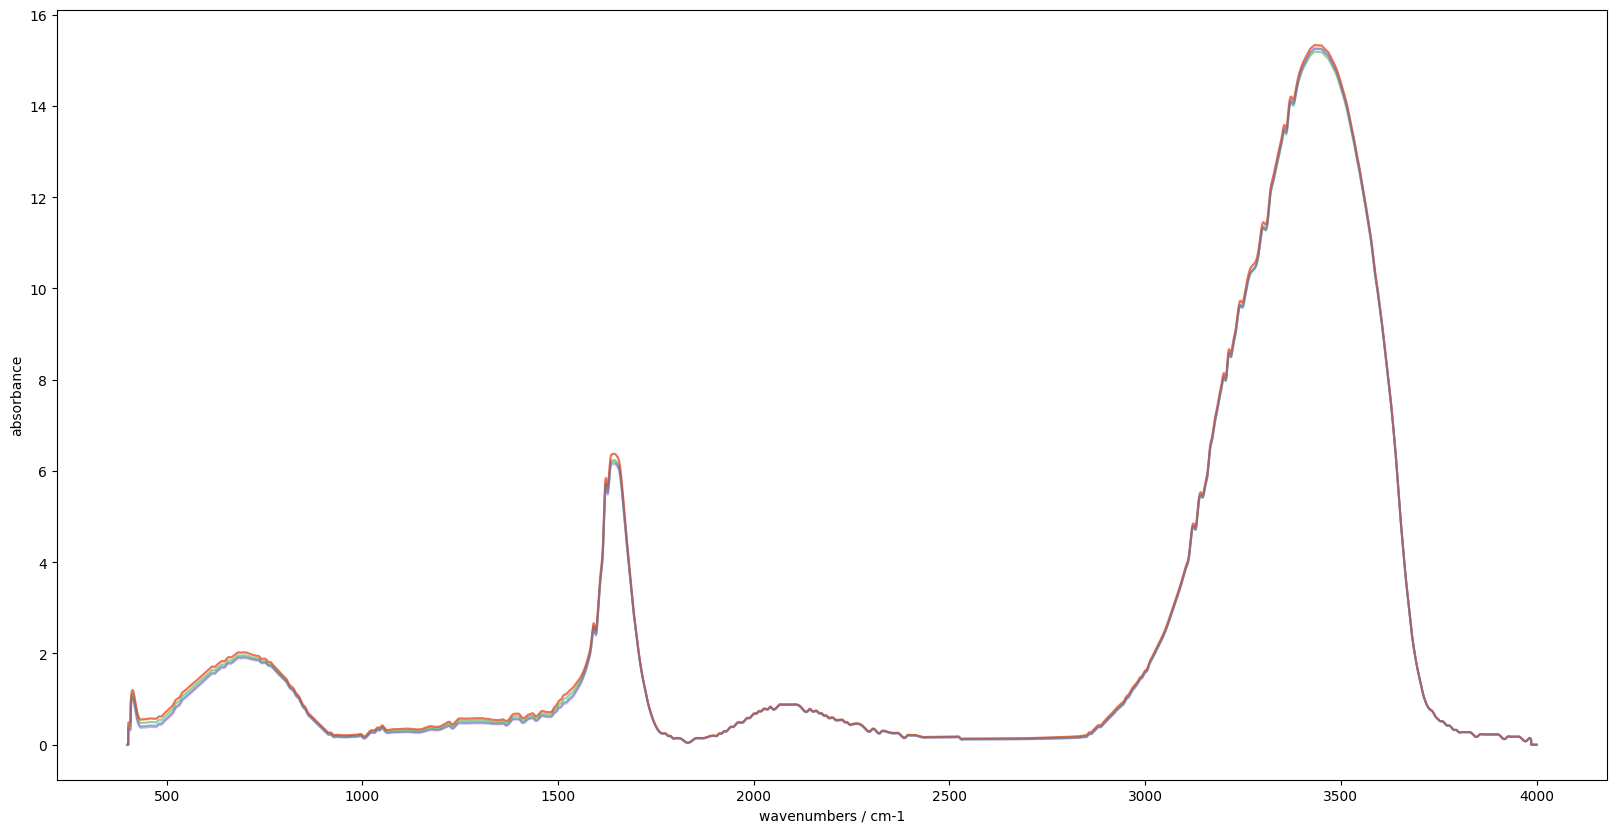

In [43]:
plt.figure(figsize=(20, 10))
for i in range(5):
    a = Mixture(chemicals)
    a.normalizedWithBackground("water")
    a.plot("overlap", "absorbance")